# Battle of Neighborhoods : Taste of Morocco

## 1. Introduction

### 1.1 Description and Background

Canada is a historical land of immigration, and this cultural mesh created a very wide and rich display of different cultures, colors and tastes. At each corner people can find a variety of ethnical cuisine restaurants and shops, some more widely popular than others.  

As many type of cuisines already are famous (italian, american) or many that benefits from a booming interest (asian, japanese) ther are yet continents that are timidly trying to make their food get some keen interest by the general public.  

African food is still not as popular in the public panel and is yet to show it's full potential, bringing unexplored flavours to the city of Toronto.  

Morocco is a historical melting pot that combines influences from plethora of cultures and ethnicities : berbers, arabs, sub saharians, phenicians, jews, romans...  

And this richness can be felt into its very traditional but exquisite cuisine but unfortunately not as well known.  

The goal of this project would be to open a **restaurant chain of moroccan themed food with some african twist**. The simultaneous presence of the stores would have a great impact for advertising moroccan food across the city.

## 2. Data

### 2.1 Description of the Data

The data to use would consist in boroughs and neighboroughs of the city of **Toronto** famous for their restaurant and ethnic food concentration. Spots that are well known by foodies and that already holds a customer basis.   

The data should also pinpoint areas with good potential that is free from fierce concurrence.    

The source of data would be a combination of **Wikipedia** boroughs list with **Foursquare API** data of Toronto Venues.  

The classification should be made regarding the ethnical type of food served and be analyzed regarding similar type of foods.

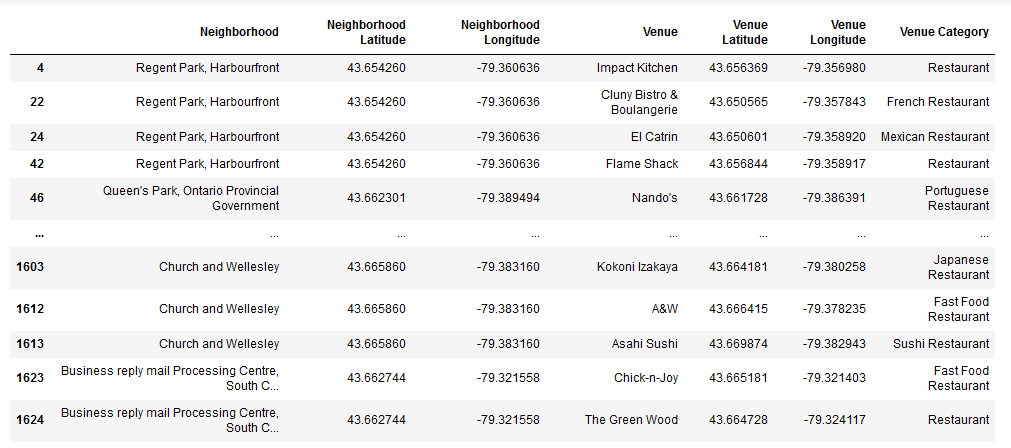

In [1]:
from IPython.display import Image
Image(filename='venues_type.png')

### 2.2 Data Extraction : Toronto Boroughs from Wikipedia

We are going to extract all the **Toronto Boroughs** name and confornt them with their rescpective coordinate data to generate a Dataframe basis

Scraping the data from Wikipedia

In [2]:
import requests

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
response

from bs4 import BeautifulSoup

soup = BeautifulSoup(response.text,'html.parser')
type(soup)

result = soup.find("table",class_="wikitable sortable")

Convert the Data into a Dataframe 

In [3]:
import pandas as pd
import numpy as np

dfs = pd.read_html(str(result))
df= dfs[0]

#cleaning up the useless data
na = df[df['Borough'] == 'Not assigned'].index
df.drop(na,inplace=True)
df.reset_index(drop = True,inplace=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### 2.3 Data Extraction : Combining the Boroughs with their geospatial coordinates

Importing the geospatial coordinates

In [4]:
geo = pd.read_csv('Geospatial_Coordinates.csv')

In [5]:
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging the 2 Dataframes

In [6]:
merged = pd.merge(df,geo,on=['Postal Code'])
merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Reducing down to Boroughs containing the word 'Toronto'

In [7]:
toronto_df=merged[merged['Borough'].str.contains("Toronto")]
toronto_df.columns=["Postal Code", "Borough", "Neighborhood","Latitude","Longitude"]
toronto_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


### 2.4 Data Extraction : Coupling the Tronto boroughs with Foursquare API data

In [8]:
CLIENT_ID = 'PGSXXB0HS0W0KTJNP4TE1XTTPFW431RUVC3WB0YKEA02TUUD' # your Foursquare ID
CLIENT_SECRET = 'XPJP2IQHKPRSAZ1RPZXRYVLHGSDREGJIIKO4OJXRTGBJEYUS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: PGSXXB0HS0W0KTJNP4TE1XTTPFW431RUVC3WB0YKEA02TUUD
CLIENT_SECRET:XPJP2IQHKPRSAZ1RPZXRYVLHGSDREGJIIKO4OJXRTGBJEYUS


In [9]:
# defining radius and limit of venues to get
radius=500
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Listing Toronto Venues**

In [10]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],latitudes=toronto_df['Latitude'],longitudes=toronto_df['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [11]:
print("Toronto Venues Shape : ",toronto_venues.shape)
toronto_venues.head(10)

Toronto Venues Shape :  (1642, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
5,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park
6,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub
7,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
8,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
9,"Regent Park, Harbourfront",43.65426,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center


**!!! Pickling data !!!**

(Pickling data in case of Api limit reach or connection problems)

In [12]:
import pickle

In [13]:
pickle_out = open("Foursquare_toronto_venues.pickle","wb")
pickle.dump(toronto_venues,pickle_out)
pickle_out.close()

print("pickled")

pickled


**!!! End Pickling data !!!**

## 3. Methodology

### 3.1 Isolating the different restaurant types

**Identifying the different ype of venues and isolating the restaurants**

In [14]:
venue_categories = toronto_venues.groupby('Venue Category').count()
venue_categories

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Airport,1,1,1,1,1,1
Airport Food Court,1,1,1,1,1,1
Airport Gate,1,1,1,1,1,1
Airport Lounge,2,2,2,2,2,2
Airport Service,3,3,3,3,3,3
...,...,...,...,...,...,...
Vietnamese Restaurant,7,7,7,7,7,7
Wine Bar,10,10,10,10,10,10
Wine Shop,2,2,2,2,2,2


**Listing the different restaurant types**

In [15]:
restaurant_type = []
for i in venue_categories.index:
    if 'Restaurant' in i:
        print(i)
        restaurant_type.append(i)
    

American Restaurant
Asian Restaurant
Belgian Restaurant
Brazilian Restaurant
Cajun / Creole Restaurant
Caribbean Restaurant
Chinese Restaurant
Colombian Restaurant
Comfort Food Restaurant
Cuban Restaurant
Dim Sum Restaurant
Doner Restaurant
Dumpling Restaurant
Eastern European Restaurant
Ethiopian Restaurant
Falafel Restaurant
Fast Food Restaurant
Filipino Restaurant
French Restaurant
German Restaurant
Gluten-free Restaurant
Greek Restaurant
Indian Restaurant
Italian Restaurant
Japanese Restaurant
Korean Restaurant
Latin American Restaurant
Malay Restaurant
Mediterranean Restaurant
Mexican Restaurant
Middle Eastern Restaurant
Modern European Restaurant
Molecular Gastronomy Restaurant
Moroccan Restaurant
New American Restaurant
Persian Restaurant
Portuguese Restaurant
Ramen Restaurant
Restaurant
Seafood Restaurant
Sushi Restaurant
Taiwanese Restaurant
Thai Restaurant
Theme Restaurant
Vegetarian / Vegan Restaurant
Vietnamese Restaurant


**Isolating the restaurants**

In [16]:
restaurant_type_list = []
for i, row_i in toronto_venues.iterrows():
    #print(row_i['Venue Category'])
    if row_i['Venue Category'] in restaurant_type:
        restaurant_type_list.append(row_i)


In [17]:
restaurant_type_list

[Neighborhood              Regent Park, Harbourfront
 Neighborhood Latitude                       43.6543
 Neighborhood Longitude                     -79.3606
 Venue                                Impact Kitchen
 Venue Latitude                              43.6564
 Venue Longitude                             -79.357
 Venue Category                           Restaurant
 Name: 4, dtype: object,
 Neighborhood              Regent Park, Harbourfront
 Neighborhood Latitude                       43.6543
 Neighborhood Longitude                     -79.3606
 Venue                                     El Catrin
 Venue Latitude                              43.6506
 Venue Longitude                            -79.3589
 Venue Category                   Mexican Restaurant
 Name: 22, dtype: object,
 Neighborhood               Regent Park, Harbourfront
 Neighborhood Latitude                        43.6543
 Neighborhood Longitude                      -79.3606
 Venue                     Cluny Bistro & Bou

**Regroup the data into a pandas dataframe**

In [18]:
toronto_resto = pd.DataFrame(restaurant_type_list)
toronto_resto.reset_index(drop=True,inplace=True)
print("Toronto Resto shape : ",toronto_resto.shape)
toronto_resto.head()

Toronto Resto shape :  (383, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
1,"Regent Park, Harbourfront",43.654260,-79.360636,El Catrin,43.650601,-79.358920,Mexican Restaurant
2,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
3,"Regent Park, Harbourfront",43.654260,-79.360636,Flame Shack,43.656844,-79.358917,Restaurant
4,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Nando's,43.661728,-79.386391,Portuguese Restaurant


### 3.2 Displaying the different restaurants on a map

**Importing the necessary libraries**

In [19]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

**Creating the map**

In [20]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="xxx")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [21]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, venue_cat,neighborhood in zip(toronto_resto['Venue Latitude'], toronto_resto['Venue Longitude'], toronto_resto['Venue Category'], toronto_resto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, venue_cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**Sorting Restaurants by frequency**

In [22]:
toronto_resto['Venue Category'].value_counts()

Restaurant                         55
Italian Restaurant                 38
Japanese Restaurant                33
Sushi Restaurant                   24
Seafood Restaurant                 22
American Restaurant                21
Vegetarian / Vegan Restaurant      17
Thai Restaurant                    16
Asian Restaurant                   13
Greek Restaurant                   12
Fast Food Restaurant               11
Mexican Restaurant                 10
French Restaurant                  10
Chinese Restaurant                  9
New American Restaurant             9
Middle Eastern Restaurant           7
Indian Restaurant                   7
Vietnamese Restaurant               7
Comfort Food Restaurant             6
Caribbean Restaurant                5
Mediterranean Restaurant            4
Ramen Restaurant                    4
Latin American Restaurant           4
Eastern European Restaurant         3
Gluten-free Restaurant              3
Modern European Restaurant          3
Cuban Restau

**Defining where the moroccan Venues are located**

In [23]:
toronto_resto[toronto_resto['Venue Category'] == 'Moroccan Restaurant']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
50,St. James Town,43.651494,-79.375418,Berber SOCIAL,43.648114,-79.374046,Moroccan Restaurant
51,St. James Town,43.651494,-79.375418,The Sultan's Tent and Cafe Moroc,43.647928,-79.374341,Moroccan Restaurant


**We can notice that there are only 2 moroccan restaurants in all the areas scouted, both located in the neighborhood of St. James Town**

### 3.3 Analysing each Restaurant Type

In [24]:
toronto_onehot = pd.get_dummies(toronto_resto[['Venue Category']],prefix="",prefix_sep="")

toronto_onehot.head()

,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [25]:

toronto_onehot['Neighborhood'] = toronto_resto['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()


,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,"Queen's Park, Ontario Provincial Government",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [26]:
toronto_onehot.shape

(383, 47)

In [27]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,...,0.000000,0.000000,0.153846,0.153846,0.076923,0.0,0.076923,0.0,0.076923,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,"Business reply mail Processing Centre, South C...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,Central Bay Street,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.055556,0.055556,0.055556,0.000000,0.055556,0.0,0.055556,0.0,0.055556,0.0
4,Christie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


**Restaurant frequency per neighborhood**

In [28]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0  Seafood Restaurant  0.15
1          Restaurant  0.15
2  Italian Restaurant  0.08
3    Greek Restaurant  0.08
4   French Restaurant  0.08


----Brockton, Parkdale Village, Exhibition Place----
                       venue  freq
0         Italian Restaurant   0.5
1                 Restaurant   0.5
2    New American Restaurant   0.0
3          Korean Restaurant   0.0
4  Latin American Restaurant   0.0


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                       venue  freq
0       Fast Food Restaurant   0.5
1                 Restaurant   0.5
2        American Restaurant   0.0
3    New American Restaurant   0.0
4  Latin American Restaurant   0.0


----Central Bay Street----
                           venue  freq
0             Italian Restaurant  0.17
1            Japanese Restaurant  0.11
2  Vegetarian / Vegan Restaurant  0.06
3          Portuguese Restaurant  0.06
4              Ind

**Regroup data into pandas Dataframe**

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant Type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant Type'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,6th Most Common Restaurant Type,7th Most Common Restaurant Type,8th Most Common Restaurant Type,9th Most Common Restaurant Type,10th Most Common Restaurant Type
0,Berczy Park,Seafood Restaurant,Restaurant,Comfort Food Restaurant,Thai Restaurant,Greek Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,French Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Italian Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
2,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,Central Bay Street,Italian Restaurant,Japanese Restaurant,Indian Restaurant,New American Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Middle Eastern Restaurant,Falafel Restaurant,Modern European Restaurant
4,Christie,Italian Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
5,Church and Wellesley,Japanese Restaurant,Sushi Restaurant,Restaurant,Mediterranean Restaurant,Indian Restaurant,Persian Restaurant,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Mexican Restaurant
6,"Commerce Court, Victoria Hotel",Restaurant,American Restaurant,Seafood Restaurant,Japanese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,New American Restaurant,Gluten-free Restaurant,Latin American Restaurant
7,Davisville,Sushi Restaurant,Italian Restaurant,Indian Restaurant,Greek Restaurant,Thai Restaurant,Seafood Restaurant,Restaurant,Dim Sum Restaurant,Filipino Restaurant,Fast Food Restaurant
8,"Dufferin, Dovercourt Village",Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
9,"First Canadian Place, Underground city",Japanese Restaurant,Restaurant,American Restaurant,Asian Restaurant,Seafood Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Italian Restaurant,Fast Food Restaurant


### 3.4 Clustering the Neighborhood

**Using a K-Elbow Test to define the optimal number of clusters**

In [31]:
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

c:\users\marwane\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [32]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

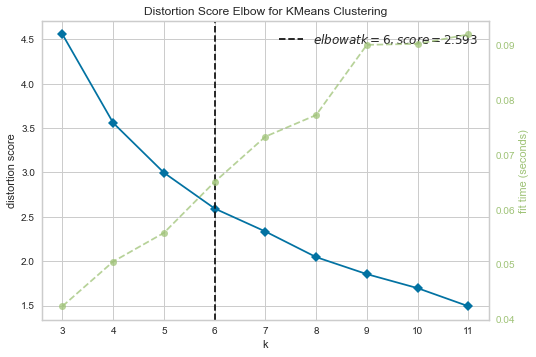

In [33]:
X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)

#Instantiate the clustering model and visualizer
model = KMeans().fit(toronto_grouped_clustering)
visualizer = KElbowVisualizer(model, k=(3,12))

visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the fi

**Using Elbow Score, we can figure that the optimal number of clusters is : K = 6**

In [34]:
# set number of clusters
kclusters = 6

#toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 0, 0, 5, 0, 5, 5, 5, 1, 5])

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,6th Most Common Restaurant Type,7th Most Common Restaurant Type,8th Most Common Restaurant Type,9th Most Common Restaurant Type,10th Most Common Restaurant Type
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Restaurant,French Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,5.0,Vegetarian / Vegan Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Portuguese Restaurant,Persian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,5.0,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Ramen Restaurant,Vietnamese Restaurant,New American Restaurant,Ethiopian Restaurant,Mexican Restaurant,Chinese Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,5.0,American Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,Moroccan Restaurant,New American Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Middle Eastern Restaurant
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,2.0,Asian Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


**Mapping the clusters**

In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

c = 0
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)

    c = c+1
   # print("# Cluster : ",type(cluster))
   # print("# Cluster : ",cluster)
    if np.isnan(cluster) == True:
        cluster = 0.0
    
    cluster = int(cluster)
    
    
        
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
        
print(c)        
map_clusters

39


### 3.5 Examine the Clusters

**Cluster 1**

In [37]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0,toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]
cluster1

,Borough,Neighborhood,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,6th Most Common Restaurant Type,7th Most Common Restaurant Type,8th Most Common Restaurant Type,9th Most Common Restaurant Type,10th Most Common Restaurant Type
2,Downtown Toronto,"Regent Park, Harbourfront",0.0,Restaurant,French Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
25,Downtown Toronto,Christie,0.0,Italian Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
36,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",0.0,Restaurant,Italian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Seafood Restaurant,Japanese Restaurant,Chinese Restaurant,New American Restaurant,Doner Restaurant
43,West Toronto,"Brockton, Parkdale Village, Exhibition Place",0.0,Italian Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
47,East Toronto,"India Bazaar, The Beaches West",0.0,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
73,Central Toronto,"North Toronto West, Lawrence Park",0.0,Italian Restaurant,Fast Food Restaurant,Seafood Restaurant,Restaurant,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant,French Restaurant,Filipino Restaurant
75,West Toronto,"Parkdale, Roncesvalles",0.0,Italian Restaurant,Restaurant,Eastern European Restaurant,Cuban Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
100,East Toronto,"Business reply mail Processing Centre, South C...",0.0,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant


In [38]:
cluster1['1st Most Common Restaurant Type'].unique()

array(['Restaurant', 'Italian Restaurant', 'Fast Food Restaurant'],
      dtype=object)

**Cluster 2**

In [39]:
cluster2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1,toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]
cluster2

,Borough,Neighborhood,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,6th Most Common Restaurant Type,7th Most Common Restaurant Type,8th Most Common Restaurant Type,9th Most Common Restaurant Type,10th Most Common Restaurant Type
31,West Toronto,"Dufferin, Dovercourt Village",1.0,Middle Eastern Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant


In [40]:
cluster2['1st Most Common Restaurant Type'].unique()

array(['Middle Eastern Restaurant'], dtype=object)

**Cluster 3**

In [41]:
cluster3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2,toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]
cluster3

,Borough,Neighborhood,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,6th Most Common Restaurant Type,7th Most Common Restaurant Type,8th Most Common Restaurant Type,9th Most Common Restaurant Type,10th Most Common Restaurant Type
19,East Toronto,The Beaches,2.0,Asian Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


**Cluster 4**

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3,toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,6th Most Common Restaurant Type,7th Most Common Restaurant Type,8th Most Common Restaurant Type,9th Most Common Restaurant Type,10th Most Common Restaurant Type
68,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",3.0,Sushi Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant


**Cluster 5**

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4,toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,6th Most Common Restaurant Type,7th Most Common Restaurant Type,8th Most Common Restaurant Type,9th Most Common Restaurant Type,10th Most Common Restaurant Type
74,Central Toronto,"The Annex, North Midtown, Yorkville",4.0,Indian Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Belgian Restaurant,Eastern European Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant


**Cluster 6**

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5,toronto_merged.columns[[1,2] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Restaurant Type,2nd Most Common Restaurant Type,3rd Most Common Restaurant Type,4th Most Common Restaurant Type,5th Most Common Restaurant Type,6th Most Common Restaurant Type,7th Most Common Restaurant Type,8th Most Common Restaurant Type,9th Most Common Restaurant Type,10th Most Common Restaurant Type
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",5.0,Vegetarian / Vegan Restaurant,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Portuguese Restaurant,Persian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant
9,Downtown Toronto,"Garden District, Ryerson",5.0,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Ramen Restaurant,Vietnamese Restaurant,New American Restaurant,Ethiopian Restaurant,Mexican Restaurant,Chinese Restaurant
15,Downtown Toronto,St. James Town,5.0,American Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,Moroccan Restaurant,New American Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Middle Eastern Restaurant
20,Downtown Toronto,Berczy Park,5.0,Seafood Restaurant,Restaurant,Comfort Food Restaurant,Thai Restaurant,Greek Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,French Restaurant
24,Downtown Toronto,Central Bay Street,5.0,Italian Restaurant,Japanese Restaurant,Indian Restaurant,New American Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Middle Eastern Restaurant,Falafel Restaurant,Modern European Restaurant
30,Downtown Toronto,"Richmond, Adelaide, King",5.0,Restaurant,Thai Restaurant,American Restaurant,Sushi Restaurant,Colombian Restaurant,Gluten-free Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant
37,West Toronto,"Little Portugal, Trinity",5.0,Asian Restaurant,Vietnamese Restaurant,Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,New American Restaurant,Cuban Restaurant
41,East Toronto,"The Danforth West, Riverdale",5.0,Greek Restaurant,Italian Restaurant,Restaurant,Indian Restaurant,Caribbean Restaurant,American Restaurant,Sushi Restaurant,Seafood Restaurant,Filipino Restaurant,Fast Food Restaurant
42,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",5.0,Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant,Seafood Restaurant,Asian Restaurant,French Restaurant,New American Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant
48,Downtown Toronto,"Commerce Court, Victoria Hotel",5.0,Restaurant,American Restaurant,Seafood Restaurant,Japanese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,New American Restaurant,Gluten-free Restaurant,Latin American Restaurant


## 4. Results

By analyzing the data we can clearly identify a pattern that draws itself.    

We can see that the clusters **1,2,3,4** and **6** concentrate their restaurants into specific areas of Toronto (West, East, Central) areas.  

While the richest variety of restaurants considered is located within the **Downtown area** (Cluster 5), which can seem logical at first glance regarding the historical aspect of the site.  

As we did see previously, the sole moroccan venues are located in the same area **St. James Town** in **Downtown Toronto** :

In [45]:
toronto_resto[toronto_resto['Venue Category'] == 'Moroccan Restaurant']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
50,St. James Town,43.651494,-79.375418,Berber SOCIAL,43.648114,-79.374046,Moroccan Restaurant
51,St. James Town,43.651494,-79.375418,The Sultan's Tent and Cafe Moroc,43.647928,-79.374341,Moroccan Restaurant


## 5. Discussion

Ultimately, and due to very few competition, the best option to open our Moroccan themed restaurant Brand would be in various areas in Downtown excepting  **St. James Town.**  

Even though opening in spots surrounding this area would be an interesting fit as it already has a customer basis looking for north african flavors.

# 6. Conclusion

In conclusion, we can clearly notice how powerful a tool machine learning and Data Science are. In a few lines of codes, and some logic we were able to make an efficient Data analysis from online available sources that mixed together can offer the premices of a solid Business plan or Marketing campaign.  
As simple of an application it can be made, this information processing can offer an invaluable amount of hints for business opportunities.